In [1]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt

In [2]:
def LeerDatos(file, sep1 : str, header = True):
    if (header):
        data = pd.read_csv(file, sep =sep1, header = 0)
    else:
        data = pd.read_csv(file, sep = sep1, header = None)
    data = data.sort_values(data.columns[-1])
    return data.to_numpy()

In [3]:
def Normalizar_Datos(data : np.array):
    for i in range (0,np.size(data[0])):
        m = np.mean(data[:,i])
        sd = np.std(data[:,i])
        data[:,i] = (data[:,i] - m)/sd
    return data

In [4]:
def Crear_k_folds(data : np.array , k:int, clases: []):
    folds = []
    tot_clase = []
    prop_clase = []
    pre_fold = []

    m = np.size(data[:,-1])

    for i in clases:
        tot_clase.append(np.count_nonzero( data[:,-1] == i))

    prop_clase.append(tot_clase[0])
    for i in range (1, len(tot_clase)):
        prop_clase.append( prop_clase[i-1] + tot_clase[i])

    pos_ini = 0
    for i in range(0, len(clases)):
        pre_fold.append(np.array_split(data[pos_ini:prop_clase[i]], k))
        pos_ini = prop_clase[i]
    
    for i in range (0,k):
        temp = np.empty( (0,np.size(data[0])) )
        for j in range(0,len(clases)):
            temp = np.vstack( (temp,pre_fold[j][i]))
        folds.append(temp)
            
    return folds

In [5]:
def Sigmoidal(X:np.array, theta:np.array):
    pot = X.dot(theta)
    return 1/(1+ np.exp(-pot))

In [6]:
def ds(D : np.array):
    return D*(1-D)

In [7]:
def Calcular_Funcion_Costo(X: np.array, y:np.array):
    m = np.size(X[:,0]) #numero de datos
    costo = 0
    for i in range(0, len(X[0])):
        costo += -1/m * ( np.sum( y[i].dot(np.log(X[i])) + (1-y[i]).dot( np.log(1-X[i]))) )
    return costo

In [8]:
def GenerarW( num_capas : int, dim_capas = []):
    W = {}
    for i in range(0,num_capas+1):
        if (i == 0):
            temp = np.random.randn( dim_capas[i], dim_capas[i+1] )
            W[i] = temp
        if (i != 0):
            temp = np.random.randn( dim_capas[i]+1, dim_capas[i+1] )
            W[i] = temp       
    return W

In [9]:
def Forward (X: np.array, W : {}): 
    hidden_l = X
    A = {}
    A[0] = hidden_l
    for i in range(0, len(W)):
        if (i == len(W)-1):
            hidden_l = Sigmoidal(hidden_l, W[i])
        else:
            hidden_l = Sigmoidal(hidden_l, W[i])
            bias = np.ones( (np.size(hidden_l[:,0]),1) )
            hidden_l = np.hstack( (bias,hidden_l) )
     
        A[i+1] = hidden_l   
    return A

def Backward (X: np.array, y: np.array, W:{}, A:{}, lr:float):
    delta_t = (A[len(A)-1] - y)
    m = np.size(X[:,-1])
    for i in range(len(W)-1,-1,-1):
        R = lr * ((A[i].T.dot(delta_t))/ m)
        if (i == len(W)-1):
            W[i]-= R
            delta_t = ds(A[i])*(delta_t.dot(W[i].T))
        else:
            R = R[:,1:]
            W[i]-= R 
        if (i != len(W)-1  and i != 0):
            delta_t = ds(A[i])*(delta_t[:,1:].dot(W[i].T))

In [10]:
def Gradiente_Descendiente(X: np.array, y:np.array, W:{},num_itera:int, lr):
    A = {}
    num_capas = len(W)
    arr_costo = np.empty(num_itera, dtype =float)
    for it in range(0, num_itera):
        A = Forward(X, W)
        arr_costo[it] = Calcular_Funcion_Costo(A[num_capas], y)
        Backward(X, y, W, A, lr)      
    return A[num_capas], arr_costo, W

In [11]:
def Onehot(y: np.array, clases:[]):num_clases = len(clases)
    vec_clases = np.empty((0,num_clases), dtype = int)
    for i in y:
        idx = clases.index(i)
        vec = [0] * num_clases
        vec[idx] = 1
        vec_clases = np.vstack ((vec_clases, vec))
    return vec_clases

def Out_Onehot(y:np.array):
    y_cat = np.zeros_like(y)

    max = np.argmax(y, axis = 1)
    for i in range(0, len(max)):
        y_cat[i,max[i]] = 1
    return y_cat

In [12]:
def Calcular_Accuracy(X:np.array, y:np.array, theta:np.array):
    y_calc = Forward(X, theta)
    y_calc = Out_Onehot(y_calc[len(y_calc)-1])
    aciertos = 0
    
    for i in (y - y_calc):
        if (np.count_nonzero(i) == 0):
            aciertos += 1
    return aciertos/np.size(y[:,0])
    
def AvgAccuracy(test:np.array, theta, k, clases):
    accu = np.zeros(k)
    for i in range(0,k):
        X_test = test[i][:,:-1]
        X_test = X_test.astype('float64')
        X_test = Normalizar_Datos(X_test)

        y_test = Onehot(test[i][:,-1], clases)

        accu[i] = Calcular_Accuracy(X_test, y_test, theta)
    return accu.mean()

In [13]:
def CalculoParametros(folds:[], k:int, iteraciones:int, alpha:float,
 num_clases:int, num_capa_hidden:int, num_neurona: int, clases:[]):
    arr_costo = []
    arr_theta = []
    arr_test = []
    for test_i in range(0, k):
        test = folds[test_i] 
        train = np.zeros( (0,np.size(folds[0][0])) )
        for train_i in range (0, k):         
            if (train_i == test_i):
                continue
            else:
                train = np.vstack( (train,folds[train_i]) )
            
        costo = []
        X_train = train[:,:-1]
        X_train = X_train.astype('float64')
        X_train = Normalizar_Datos(X_train)

        N = np.size(X_train[:,-1]) #tamaño batch
        D_in = np.size(X_train[0]) #dimension entrada
        D_out = num_clases

        #Generacion array de capas
        array_capas = []
        array_capas.append(D_in)
        for i in range(0, num_capa_hidden):
            array_capas.append(num_neurona)
        array_capas.append(D_out)

        W = GenerarW(num_capa_hidden, array_capas)

        y_train = Onehot( train[:,-1], clases)

        theta, costo, W = Gradiente_Descendiente(X_train, y_train, W, iteraciones, alpha)
        arr_theta.append(theta)
        arr_costo.append(costo)
        arr_test.append(test)
      
    return theta, arr_costo, arr_test, W

In [14]:
def CalculoP(folds:[], k:int, iteraciones:int, alpha:float,
 num_clases:int, num_capa_hidden:int, num_neurona: [], clases:[]):
    arr_costo = []
    arr_theta = []
    arr_test = []
    for test_i in range(0, k):
        test = folds[test_i] 
        print(test_i)
        train = np.zeros( (0,np.size(folds[0][0])) )
        for train_i in range (0, k):         
            if (train_i == test_i):
                continue
            else:
                train = np.vstack( (train,folds[train_i]) )
            
        costo = []
        X_train = train[:,:-1]
        X_train = X_train.astype('float64')
        X_train = Normalizar_Datos(X_train)

        N = np.size(X_train[:,-1]) #tamaño batch
        D_in = np.size(X_train[0]) #dimension entrada
        D_out = num_clases

        #Generacion array de capas
        array_capas = []
        array_capas.append(D_in)
        for i in range(0, num_capa_hidden):
            array_capas.append(num_neurona[i])
        array_capas.append(D_out)
        
        W = GenerarW(num_capa_hidden, array_capas)

        y_train = Onehot( train[:,-1], clases)

        theta, costo, W = Gradiente_Descendiente(X_train, y_train, W, iteraciones, alpha)
        arr_theta.append(theta)
        arr_costo.append(costo)
        arr_test.append(test)
      
    return theta, arr_costo, arr_test, W

In [15]:
def Parametros(folds:[], k, num_clases, clases:[]):
    alpha = [0.1, 0.2, 0.3, 0.4 ,0.5]
    iteraciones = range(500,3001,500)
    num_capa = [1,2,3,4,5]
    num_neurona = range(1,5,1)
    arr_accu = np.empty( (len(alpha),len(iteraciones) ))
    for nc in num_capa:
        print ("CAPAS ESCONDIDAS: ", nc)
        for nn in num_neurona:
            print ("\nNro. de neuronas por capa: ", nn)
            for tasa in range(0,len(alpha)):
                for it in range(0, len(iteraciones)):
                    theta, dummy, test, W = CalculoParametros(folds, k, iteraciones[it], alpha[tasa], num_clases, nc, nn, clases)

                    arr_accu[tasa,it] = AvgAccuracy(test, W, k, clases)
            
            print(pd.DataFrame(arr_accu, index = alpha, columns = iteraciones))

In [16]:
titanic = LeerDatos("titanic_all.csv", separa = ',')
titanic_clases = [0,1]
titanic_folds = Crear_k_folds(titanic, 3, titanic_clases)

In [17]:
Parametros(titanic_folds, 3, num_clases = 2, clases = titanic_clases)

CAPAS ESCONDIDAS:  1

Nro. de neuronas por capa:  1
          500      1000      1500      2000      2500      3000
0.1  0.602110  0.850458  0.848537  0.848537  0.848537  0.849497
0.2  0.847576  0.848537  0.848537  0.850458  0.850458  0.849497
0.3  0.848537  0.848537  0.848537  0.850458  0.848537  0.848537
0.4  0.848537  0.850458  0.849497  0.848537  0.848537  0.848537
0.5  0.849497  0.848537  0.848537  0.849497  0.850458  0.848537

Nro. de neuronas por capa:  2
          500      1000      1500      2000      2500      3000
0.1  0.838953  0.849497  0.848537  0.848537  0.848537  0.850458
0.2  0.848537  0.848537  0.848537  0.849497  0.848537  0.848537
0.3  0.850458  0.848537  0.850458  0.846615  0.851413  0.848537
0.4  0.848537  0.849497  0.849497  0.851413  0.851413  0.851413
0.5  0.848537  0.849497  0.848537  0.851413  0.848537  0.848537

Nro. de neuronas por capa:  3
          500      1000      1500      2000      2500      3000
0.1  0.849503  0.846615  0.845655  0.850458  0.848537 

0
1
2
0.8533342141262672


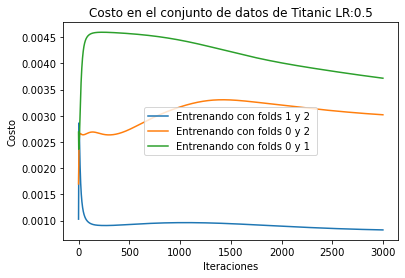

In [19]:
num_neurona = [15]
theta, arr_costo, arr_test, W = CalculoCustom(titanic_folds, k=3, iteraciones=3000,alpha=0.5, num_clases=2, num_capa_hidden=1, num_neurona=num_neurona, clases=titanic_clases)

acc = AvgAccuracy(arr_test, W, k=3, clases=titanic_clases)
print(acc)

plt.plot(arr_costo[0], label='Entrenando con folds 1 y 2 ')
plt.plot(arr_costo[1],label='Entrenando con folds 0 y 2')
plt.plot(arr_costo[2],label='Entrenando con folds 0 y 1')
plt.title('Costo en el conjunto de datos de Titanic LR:0.5')
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.legend()
plt.show()

In [20]:
glass = LeerDatos("glass.csv", separa = ',')
clases = [1,2,3,5,6,7]
glass_folds = Crear_k_folds(glass, 3, clases)
Parametros(glass_folds, 3, num_clases = 6, clases = clases)

CAPAS ESCONDIDAS:  1

Nro. de neuronas por capa:  1
          500      1000      1500      2000      2500      3000
0.1  0.591341  0.666367  0.572274  0.600745  0.740999  0.712823
0.2  0.596693  0.595763  0.741128  0.609598  0.755356  0.633352
0.3  0.618988  0.736297  0.746095  0.755492  0.765018  0.774543
0.4  0.704099  0.750790  0.750661  0.769576  0.774407  0.609598
0.5  0.726900  0.619124  0.755492  0.769576  0.769440  0.769576

Nro. de neuronas por capa:  2
          500      1000      1500      2000      2500      3000
0.1  0.722326  0.712664  0.736683  0.764602  0.740584  0.754940
0.2  0.736705  0.750903  0.760164  0.731330  0.764602  0.754940
0.3  0.722598  0.750510  0.721668  0.740977  0.755334  0.769962
0.4  0.731194  0.759771  0.750654  0.736025  0.763551  0.764602
0.5  0.745687  0.769433  0.754940  0.731459  0.807687  0.750646

Nro. de neuronas por capa:  3
          500      1000      1500      2000      2500      3000
0.1  0.726492  0.751047  0.783389  0.764466  0.764602 

In [21]:
#Calculo con número de neuronas por capa a elección
num_neurona = [15]
theta, arr_costo, arr_test, W = CalculoP(glass_folds, k=3, iteraciones=3000,alpha=0.5, num_clases=6, num_capa_hidden=1, num_neurona=num_neurona, clases=clases)

acc = PromedioAccuracy(arr_test, W, k=3, clases=clases)
print(acc)

0
1
2
0.9566578213240797


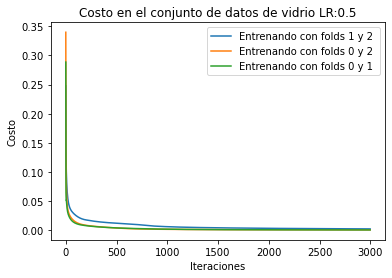

In [22]:
plt.plot(arr_costo[0], label='Entrenando con folds 1 y 2 ')
plt.plot(arr_costo[1],label='Entrenando con folds 0 y 2')
plt.plot(arr_costo[2],label='Entrenando con folds 0 y 1')
plt.title('Costo en el conjunto de datos de vidrio LR:0.5')
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.legend()
plt.show()